In [1]:

from obspy.core import read
from obspy import UTCDateTime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from functions_beamforming import latlon_to_enu,calculate_beam_power,day_process
import datetime as dt


### Set input parameters below

In [2]:

station_path='M:/Documents/agrawal/stations.csv'#csv file containing station coordinates
outdir = 'results/'#storing outputs
project_folder = '//groups.geos.ed.ac.uk/volcano_seismology/managed/s2122917/Sierra_Negra/Seismic/Dayfiles/'#data folder
start_date=dt.datetime(2018,11,1)
end_date=dt.datetime(2018,11,2)
fr = (0.1, 0.2)  # Frequency band of interest to filter the noise segments
hmin = 10 #start hour
hmax = 11 #end hour
sr = 20 #decimate to 20 samples per second after initial filtering
stations = ['VCH1','SN01', 'SN02', 'SN03', 'SN04', 'SN05', 'SN06', 'SN07','SN08','SN09', 'SN10', 'SN11', 'SN12', 'SN13', 'SN14'] #keep this order
channels = ['HHZ','HHE','HHN'] 
compute_ft=1 # set this to 1 if spectra is not calculated beofore (for initial run)

frequency_band = (0.1, 0.2)  # Frequency band of interest for beamforming computation
nfreq=1000  # Number of frequency bins to compute the integration
velocity_range = np.arange(1, 5, 0.05)  # Velocity range in km/s
azimuths = np.linspace(0, 360, 50)  # Azimuth range (0 to 360 degrees, 3 steps)
tolerance=0.001 #For making sure that the interpolated frequency value is not beyond this parameter



### loading station data

In [3]:

####### Load the station coordinates and convert them to cartesian
stn = pd.read_csv(station_path)
filtered_stn = stn[stn['code'].isin(stations)]
ref_lat = np.mean(stn['latitude'])
ref_lon = np.mean(stn['longitude'])
cartesian_coords = [latlon_to_enu(row['latitude'], row['longitude'], ref_lat, ref_lon) for _, row in filtered_stn.iterrows()]
n_days = (end_date-start_date).days


### Run the preprocessing and beamforming analysis for `n_days`

Computing spectra (expensive step), set compute_ft=0 if spectra exists
//groups.geos.ed.ac.uk/volcano_seismology/managed/s2122917/Sierra_Negra/Seismic/Dayfiles/SN05/HHZ.D/EC.SN05..HHZ.D.2018.305 not available
These stations are not included in beamforming analysis: ['SN05']
Beamforming calculation completed successfully.


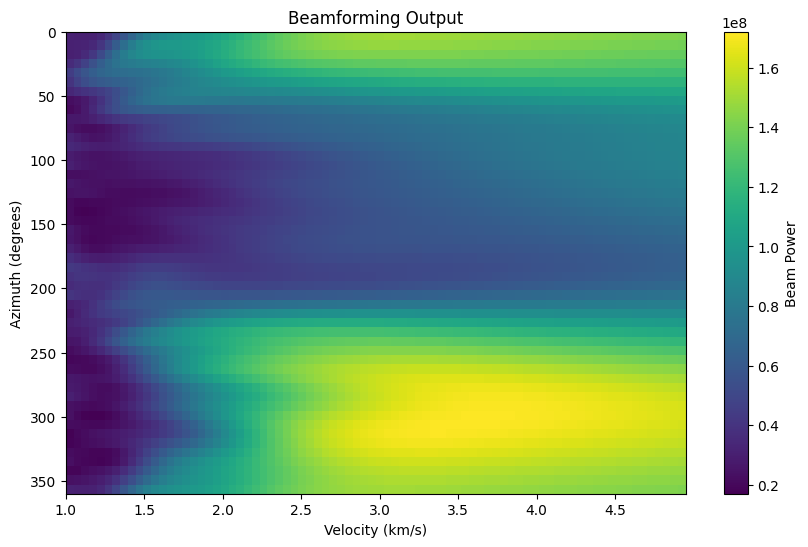

In [4]:

for i in range(n_days):
    date = start_date + dt.timedelta(days=i)
    beamforming_output = np.zeros((len(azimuths), len(velocity_range)))

    day = date.timetuple().tm_yday
    year = date.year

    if compute_ft==1:
        print(f'Computing spectra (expensive step), set compute_ft=0 if spectra exists')
        all_ft_data=[]
        data_gap=[]
        for station in stations:
                data = day_process(project_folder, station=station, 
                                           channel=channels[0], year=year, day=day, 
                                           fmin=fr[0], fmax=fr[1], hmin=hmin, hmax=hmax, 
                                           whiten=True, sr=sr)            
                if data is None:
                    data_gap.append(station)  # Track stations with missing files
                    continue
                n_samples = len(data)
                frequency = np.fft.fftfreq(n_samples, d=1/sr)
                omega = 2 * np.pi * frequency
                ft_data = np.fft.fft(data)
                freq_int=np.linspace(frequency_band[0],frequency_band[1],nfreq) #frequency array for integratio
                valid_freq_indices =  [np.argmin(np.abs(frequency - f)) for f in freq_int] #Indices for interpolated frequency values
                valid_freqs =  np.array([np.min(np.abs(frequency - f)) for f in freq_int])
                if np.any(valid_freqs > tolerance):
                    print(f"Exiting: At least one difference exceeds {tolerance} for k={k}")
                    data_gap.append(station)  # Track stations with missing files
                    continue
                else:
                    all_ft_data.append(ft_data[valid_freq_indices])
             
        np.save(f'{outdir}{day}_all_ft_data{frequency_band[0]}-{frequency_band[1]}.npy',np.array(all_ft_data))
        np.save(f'{outdir}{day}_datagap_{frequency_band[0]}-{frequency_band[1]}.npy',np.array(data_gap))


    else:
        print(f'loading pre-computed spectra (all_ft_data.npy) only if it exists')
        all_ft_data=np.load(f'{outdir}{day}_all_ft_data{frequency_band[0]}-{frequency_band[1]}.npy')
        data_gap=np.load(f'{outdir}{day}_datagap_{frequency_band[0]}-{frequency_band[1]}.npy')

    print(f'These stations are not included in beamforming analysis: {data_gap}')        

    for i,azimuth in enumerate(azimuths):
        for j,velocity in enumerate(velocity_range):
            beamforming_output[i,j]=calculate_beam_power(stations,azimuth, velocity,all_ft_data,cartesian_coords,nfreq,frequency_band,data_gap)
            
    beamforming_output = np.array(beamforming_output).reshape(len(azimuths), len(velocity_range))
    plt.figure(figsize=(10, 6))
    plt.imshow(beamforming_output, extent=[velocity_range[0], velocity_range[-1], azimuths[-1], azimuths[0]],
           aspect='auto', origin='lower')
    plt.colorbar(label="Beam Power")
    plt.xlabel("Velocity (km/s)")
    plt.ylabel("Azimuth (degrees)")
    plt.title("Beamforming Output")
    plt.savefig(outdir + f'{day}_beamforming_output_{frequency_band[0]}-{frequency_band[1]}.png')
    np.save(outdir + f'{day}_beamforming_output_{frequency_band[0]}-{frequency_band[1]}.npy', beamforming_output)
    print("Beamforming calculation completed successfully.")
